# Model Diagnostics

Comprehensive analysis of model performance, errors, and cross-validation results.


In [ ]:
import sys
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Paths
DATA_DIR = Path("../data/interim")
RESULTS_DIR = Path("../results")

# Load metadata
with open(DATA_DIR / "metadata.pkl", "rb") as f:
    metadata = pickle.load(f)
idx_to_label = metadata["idx_to_label"]
label_to_idx = metadata["label_to_idx"]
categories = list(label_to_idx.keys())

# Load training results (saved from train.ipynb)
with open(RESULTS_DIR / "training_results.pkl", "rb") as f:
    training_results = pickle.load(f)

history = training_results["history"]
cv_results = training_results["cv_results"]
results = training_results["test_results"]
n_classes = training_results["n_classes"]

labels = [idx_to_label[i] for i in range(n_classes)]

# Load tuning results if available (from hyperparameter optimization)
tuning_results = None
tuning_file = RESULTS_DIR / "tuning_results.pkl"
if tuning_file.exists():
    with open(tuning_file, "rb") as f:
        tuning_results = pickle.load(f)
    print(f"Loaded tuning results from {tuning_file}")
else:
    print("No tuning results found (run hyperparameter optimization in train.ipynb)")

print(f"Categories: {categories}")
print(f"Loaded results from {RESULTS_DIR / 'training_results.pkl'}")


Categories: ['Angry', 'Defense', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']
Loaded results from ../results/training_results.pkl


In [2]:
# Load test data for spectrogram visualization
X_test = np.load(DATA_DIR / "X_test.npy")
y_test = np.load(DATA_DIR / "y_test.npy")

print(f"Test data loaded: {X_test.shape}")
print(f"Training history: {len(history['train_loss'])} epochs")
print(f"CV results: {len(cv_results['fold_results'])} folds")
print(f"Test accuracy: {results['accuracy']:.1%}")


Test data loaded: (20, 128, 173)
Training history: 100 epochs
CV results: 5 folds
Test accuracy: 50.0%


## 1. Cross-Validation Analysis


In [3]:
# CV results loaded from training_results.pkl
print(f"CV Accuracy: {cv_results['mean_acc']:.1%} ± {cv_results['std_acc']:.1%}")
fold_accs = [f"{r['best_val_acc']:.1%}" for r in cv_results['fold_results']]
print(f"Folds: {fold_accs}")


CV Accuracy: 70.0% ± 10.8%
Folds: ['62.5%', '56.2%', '87.5%', '68.8%', '75.0%']


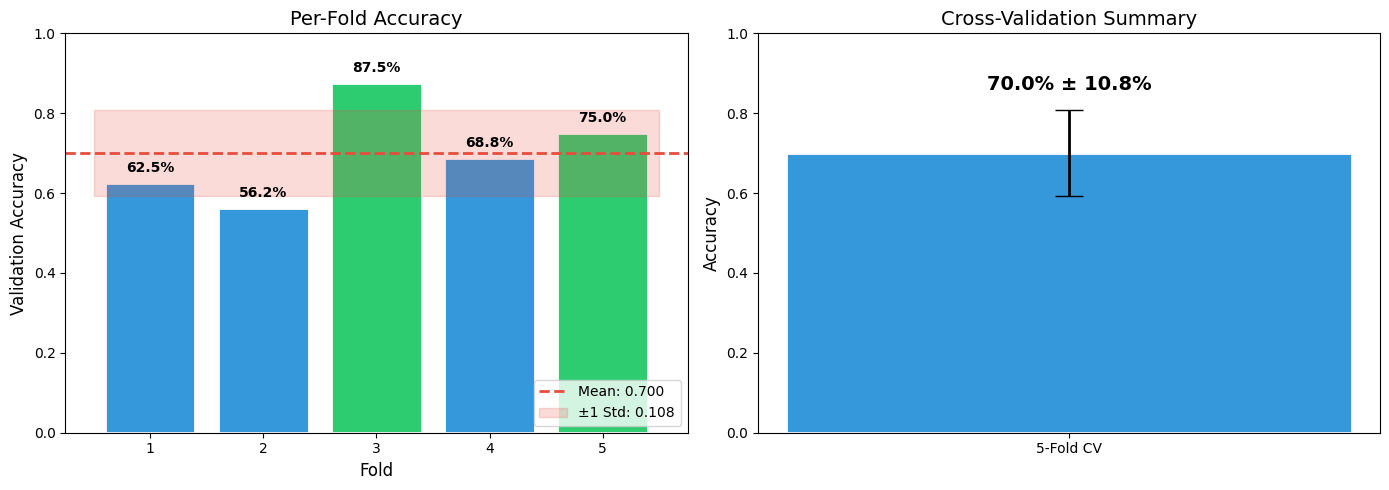

In [4]:
# Cross-validation bar plot with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Individual fold accuracies
folds = [r["fold"] for r in cv_results["fold_results"]]
accs = cv_results["accuracies"]
colors = ['#3498db' if a < cv_results['mean_acc'] else '#2ecc71' for a in accs]

bars = axes[0].bar(folds, accs, color=colors, edgecolor='white', linewidth=2)
axes[0].axhline(cv_results["mean_acc"], color='#e74c3c', linestyle='--', linewidth=2,
                label=f'Mean: {cv_results["mean_acc"]:.3f}')
axes[0].fill_between([0.5, 5.5], 
                      cv_results["mean_acc"] - cv_results["std_acc"],
                      cv_results["mean_acc"] + cv_results["std_acc"],
                      color='#e74c3c', alpha=0.2, label=f'±1 Std: {cv_results["std_acc"]:.3f}')
axes[0].set_xlabel("Fold", fontsize=12)
axes[0].set_ylabel("Validation Accuracy", fontsize=12)
axes[0].set_title("Per-Fold Accuracy", fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_xticks(folds)
axes[0].legend(loc='lower right')

# Add value labels on bars
for bar, acc in zip(bars, accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right: Summary with error bar
axes[1].bar(['5-Fold CV'], [cv_results["mean_acc"]], 
            yerr=[cv_results["std_acc"]], capsize=10, color='#3498db',
            edgecolor='white', linewidth=2, error_kw={'linewidth': 2})
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].set_title("Cross-Validation Summary", fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].text(0, cv_results["mean_acc"] + cv_results["std_acc"] + 0.05,
             f'{cv_results["mean_acc"]:.1%} ± {cv_results["std_acc"]:.1%}',
             ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### Training Curves per Fold


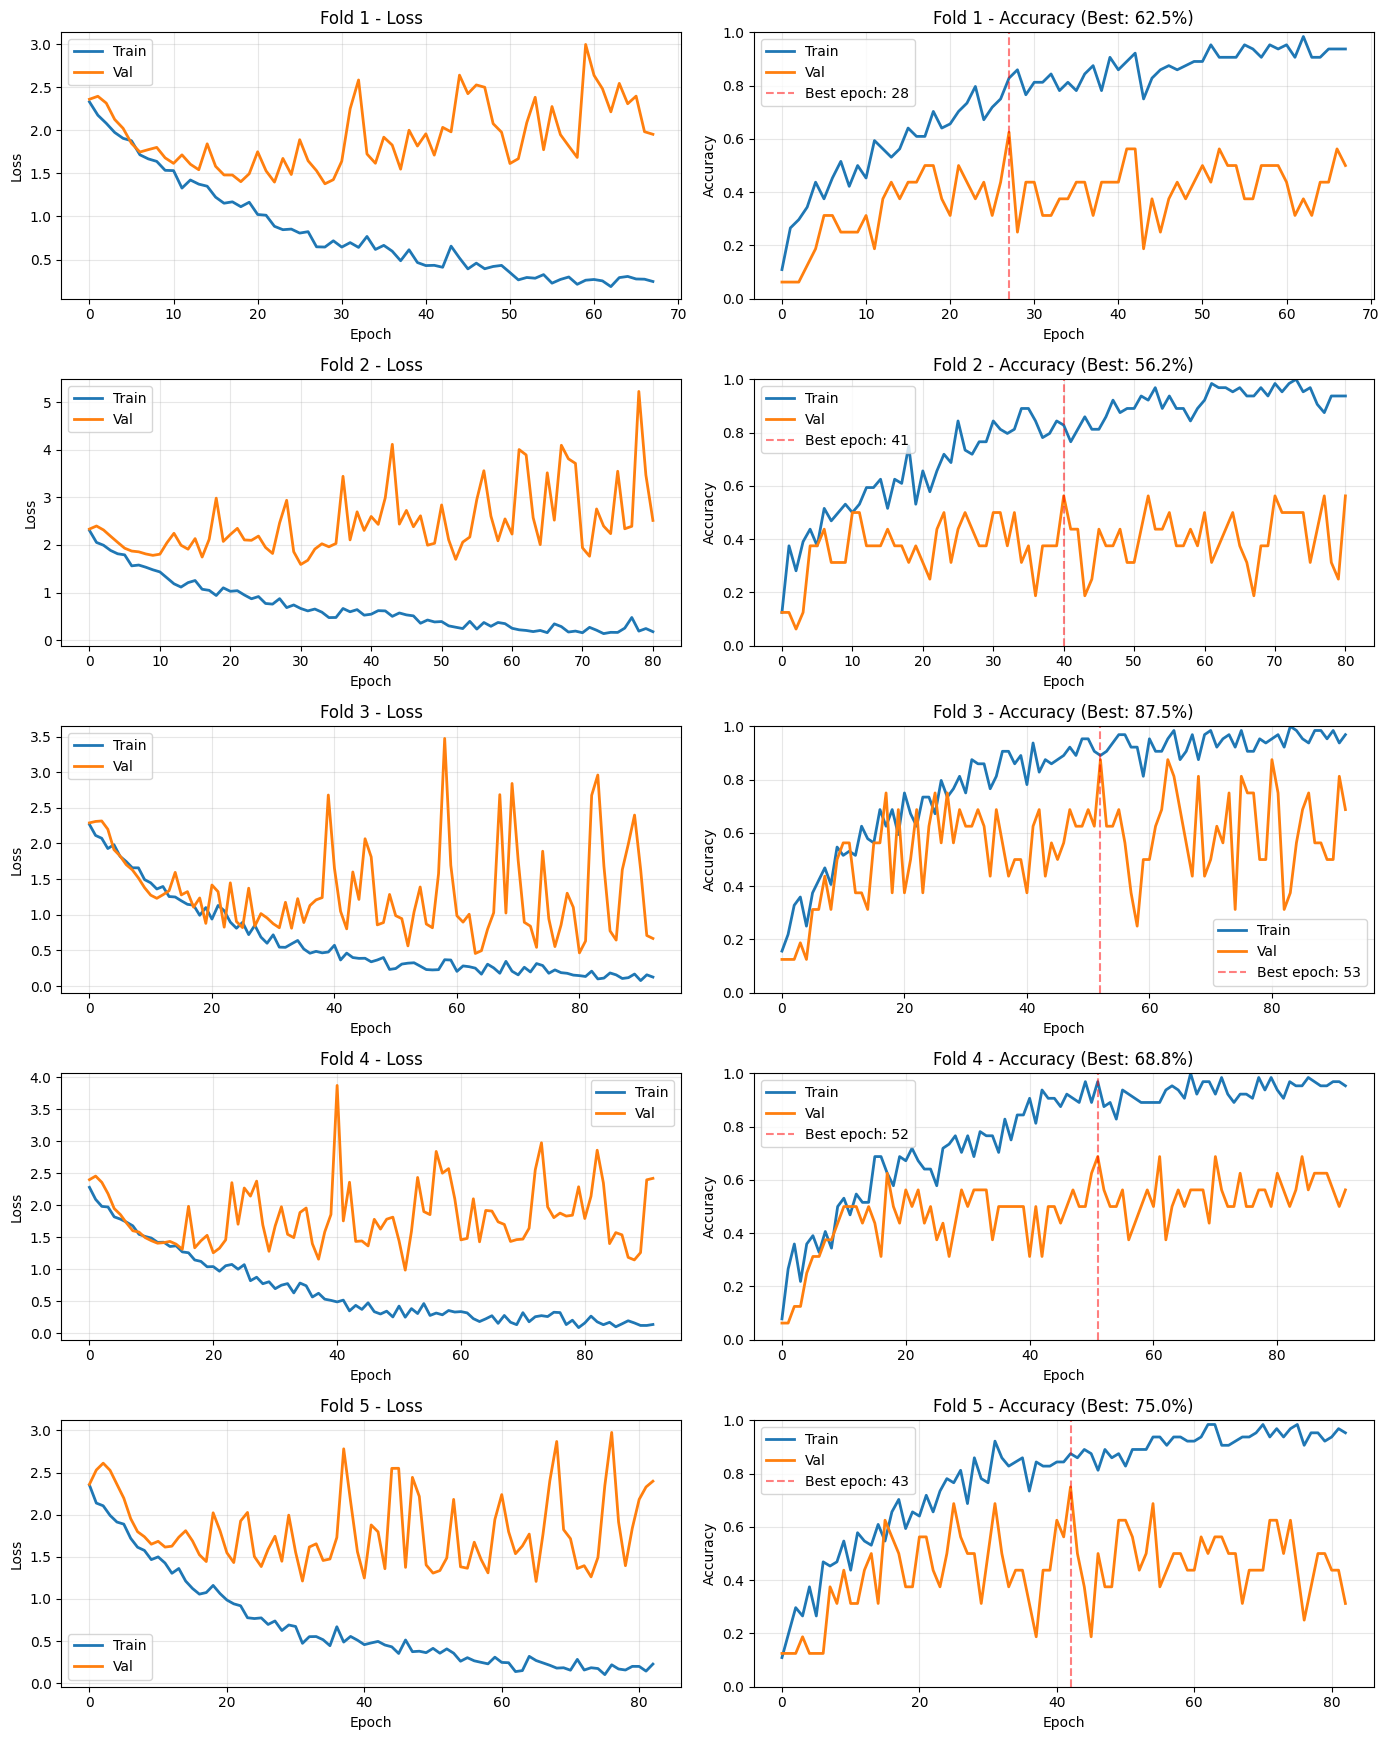

In [5]:
# Training curves for each fold
n_folds = len(cv_results["fold_results"])
fig, axes = plt.subplots(n_folds, 2, figsize=(14, 3.5 * n_folds))

for i, fold_result in enumerate(cv_results["fold_results"]):
    history = fold_result["history"]
    fold_num = fold_result["fold"]
    best_acc = fold_result["best_val_acc"]
    
    # Loss curves
    axes[i, 0].plot(history["train_loss"], label="Train", linewidth=2)
    axes[i, 0].plot(history["val_loss"], label="Val", linewidth=2)
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].set_title(f"Fold {fold_num} - Loss")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[i, 1].plot(history["train_acc"], label="Train", linewidth=2)
    axes[i, 1].plot(history["val_acc"], label="Val", linewidth=2)
    best_epoch = np.argmax(history["val_acc"])
    axes[i, 1].axvline(best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best epoch: {best_epoch+1}')
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].set_title(f"Fold {fold_num} - Accuracy (Best: {best_acc:.1%})")
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


### Single Training Run Curves


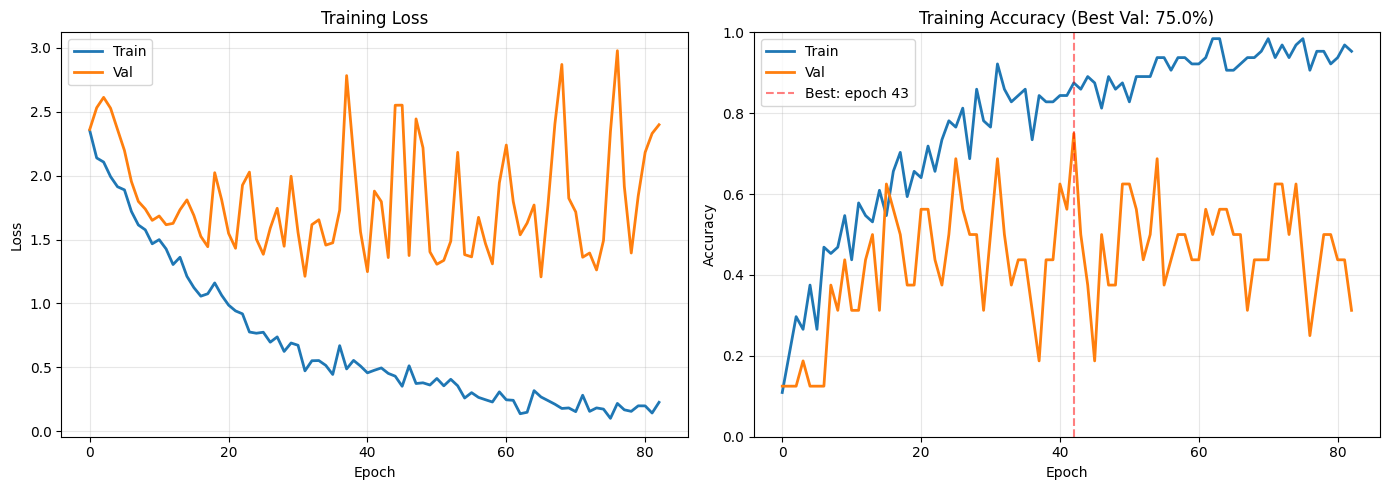

In [6]:
# Training curves from single training run
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history["train_loss"], label="Train", linewidth=2)
ax1.plot(history["val_loss"], label="Val", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history["train_acc"], label="Train", linewidth=2)
ax2.plot(history["val_acc"], label="Val", linewidth=2)
best_epoch = np.argmax(history["val_acc"])
ax2.axvline(best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best: epoch {best_epoch+1}')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title(f"Training Accuracy (Best Val: {max(history['val_acc']):.1%})")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()


## 2. Test Set Evaluation


In [7]:
# Test results loaded from training_results.pkl
print(f"Test Accuracy: {results['accuracy']:.1%}")
print(f"Test Loss: {results['loss']:.4f}")


Test Accuracy: 50.0%
Test Loss: 1.7507


### Confusion Matrix


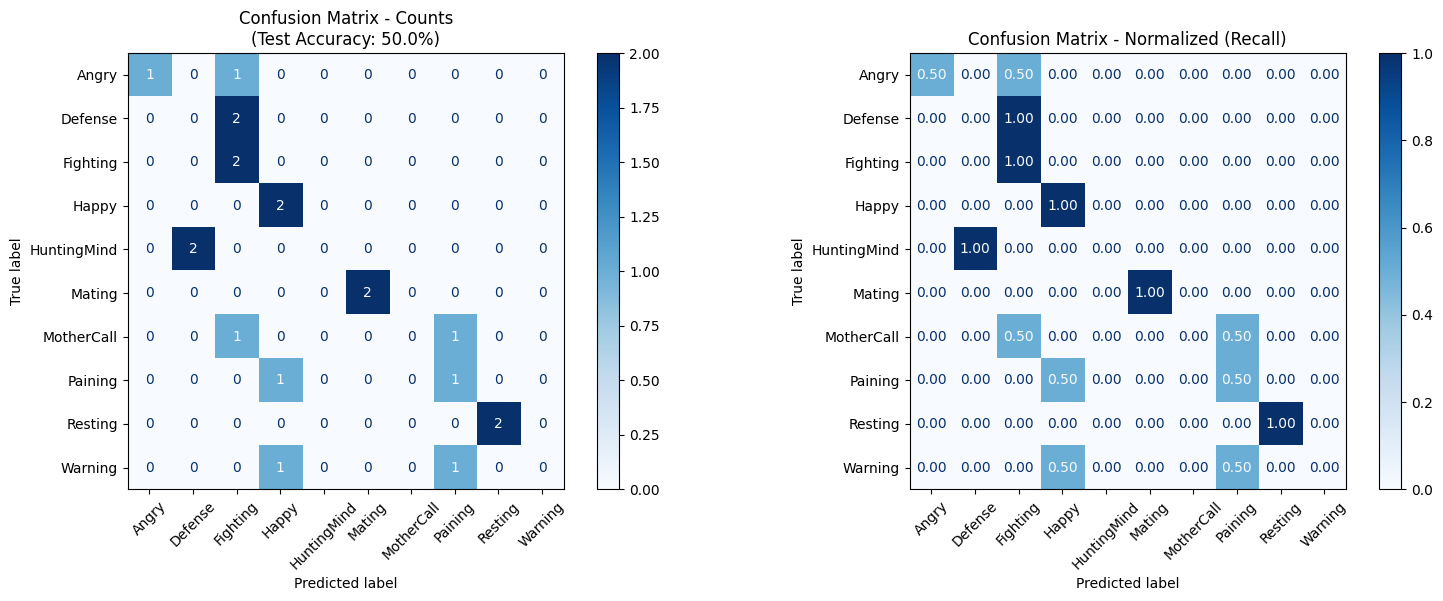

In [8]:
# Confusion matrix
cm = confusion_matrix(results["labels"], results["predictions"])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
disp1 = ConfusionMatrixDisplay(cm, display_labels=labels)
disp1.plot(ax=axes[0], cmap="Blues", xticks_rotation=45)
axes[0].set_title(f"Confusion Matrix - Counts\n(Test Accuracy: {results['accuracy']:.1%})")

# Normalized (row-wise = recall per class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)  # Handle division by zero
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
disp2.plot(ax=axes[1], cmap="Blues", xticks_rotation=45, values_format='.2f')
axes[1].set_title("Confusion Matrix - Normalized (Recall)")

plt.tight_layout()
plt.show()


### Per-Class Metrics


In [9]:
# Classification report
y_true_labels = [idx_to_label[i] for i in results["labels"]]
y_pred_labels = [idx_to_label[i] for i in results["predictions"]]

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=labels, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

       Angry       1.00      0.50      0.67         2
     Defense       0.00      0.00      0.00         2
    Fighting       0.33      1.00      0.50         2
       Happy       0.50      1.00      0.67         2
 HuntingMind       0.00      0.00      0.00         2
      Mating       1.00      1.00      1.00         2
  MotherCall       0.00      0.00      0.00         2
     Paining       0.33      0.50      0.40         2
     Resting       1.00      1.00      1.00         2
     Warning       0.00      0.00      0.00         2

    accuracy                           0.50        20
   macro avg       0.42      0.50      0.42        20
weighted avg       0.42      0.50      0.42        20



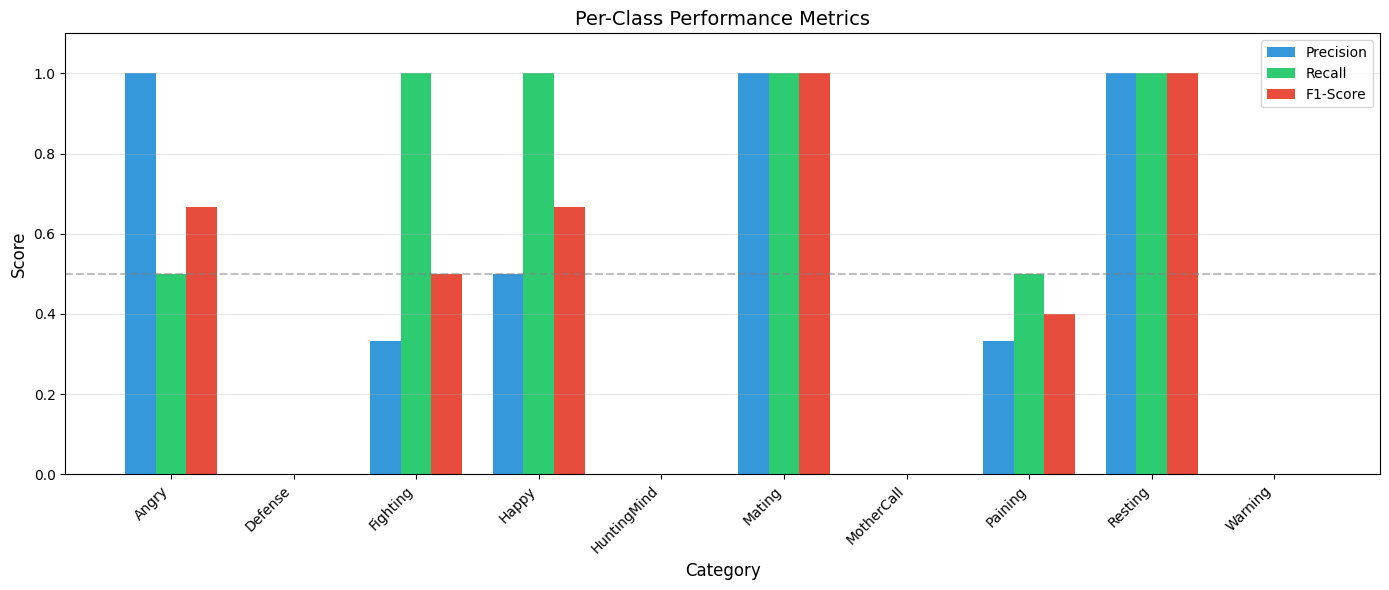

In [10]:
# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    results["labels"], results["predictions"], labels=range(n_classes), zero_division=0
)

x = np.arange(n_classes)
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 3. Error Analysis

Examine misclassified samples to understand model failures.


In [11]:
# Find misclassified samples
misclassified_idx = np.where(results["predictions"] != results["labels"])[0]
correct_idx = np.where(results["predictions"] == results["labels"])[0]

print(f"Correct: {len(correct_idx)}/{len(results['labels'])}")
print(f"Misclassified: {len(misclassified_idx)}/{len(results['labels'])}")

if len(misclassified_idx) > 0:
    print("\nMisclassified samples:")
    for idx in misclassified_idx:
        true_label = idx_to_label[results["labels"][idx]]
        pred_label = idx_to_label[results["predictions"][idx]]
        print(f"  Sample {idx}: True={true_label}, Predicted={pred_label}")


Correct: 10/20
Misclassified: 10/20

Misclassified samples:
  Sample 3: True=Defense, Predicted=Fighting
  Sample 5: True=Warning, Predicted=Paining
  Sample 6: True=Defense, Predicted=Fighting
  Sample 7: True=MotherCall, Predicted=Fighting
  Sample 9: True=Angry, Predicted=Fighting
  Sample 10: True=MotherCall, Predicted=Paining
  Sample 11: True=HuntingMind, Predicted=Defense
  Sample 14: True=HuntingMind, Predicted=Defense
  Sample 15: True=Paining, Predicted=Happy
  Sample 17: True=Warning, Predicted=Happy


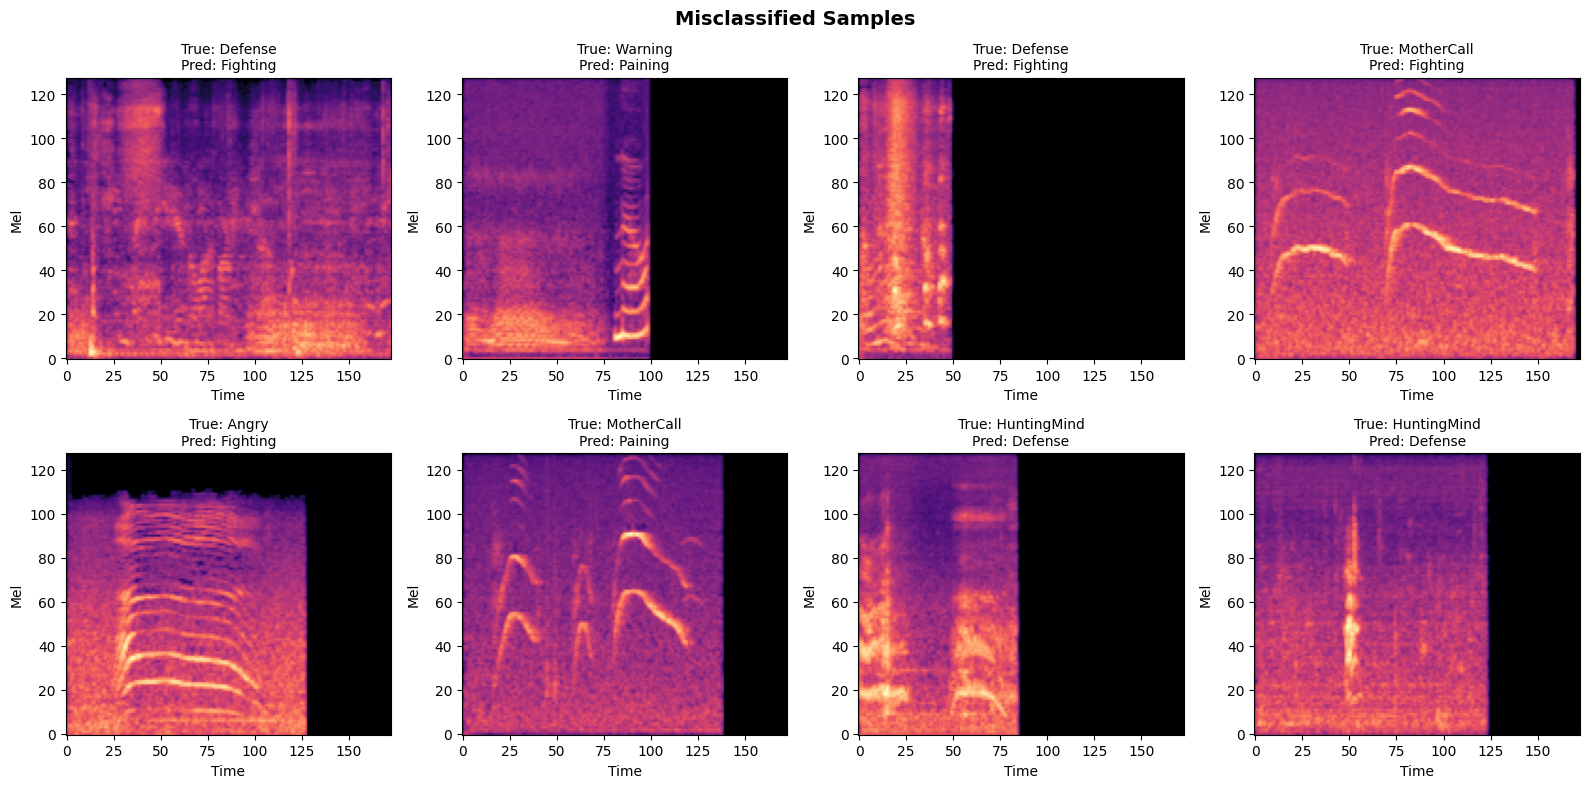

In [12]:
# Visualize misclassified spectrograms
if len(misclassified_idx) > 0:
    n_show = min(len(misclassified_idx), 8)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(n_show):
        idx = misclassified_idx[i]
        true_label = idx_to_label[results["labels"][idx]]
        pred_label = idx_to_label[results["predictions"][idx]]
        
        axes[i].imshow(X_test[idx], aspect='auto', origin='lower', cmap='magma')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("Mel")
    
    # Hide unused subplots
    for i in range(n_show, 8):
        axes[i].axis('off')
    
    plt.suptitle("Misclassified Samples", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples!")


### Most Confused Class Pairs


In [13]:
# Find most confused pairs (off-diagonal elements of confusion matrix)
confusion_pairs = []
for i in range(n_classes):
    for j in range(n_classes):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'true': labels[i],
                'predicted': labels[j],
                'count': cm[i, j]
            })

# Sort by count
confusion_pairs = sorted(confusion_pairs, key=lambda x: -x['count'])

print("Most Confused Pairs (True → Predicted):")
print("-" * 40)
for pair in confusion_pairs[:10]:
    print(f"  {pair['true']:12} → {pair['predicted']:12}: {pair['count']} times")

if not confusion_pairs:
    print("  No confusion pairs (perfect classification!)")


Most Confused Pairs (True → Predicted):
----------------------------------------
  Defense      → Fighting    : 2 times
  HuntingMind  → Defense     : 2 times
  Angry        → Fighting    : 1 times
  MotherCall   → Fighting    : 1 times
  MotherCall   → Paining     : 1 times
  Paining      → Happy       : 1 times
  Warning      → Happy       : 1 times
  Warning      → Paining     : 1 times


## 4. Summary & Recommendations


In [14]:
# Summary
print("=" * 50)
print("MODEL DIAGNOSTICS SUMMARY")
print("=" * 50)
print(f"\n📊 Cross-Validation (5-fold):")
print(f"   Accuracy: {cv_results['mean_acc']:.1%} ± {cv_results['std_acc']:.1%}")
print(f"   Best fold: {max(cv_results['accuracies']):.1%}")
print(f"   Worst fold: {min(cv_results['accuracies']):.1%}")

print(f"\n🎯 Test Set Performance:")
print(f"   Accuracy: {results['accuracy']:.1%}")
print(f"   Correct: {len(correct_idx)}/{len(results['labels'])}")
print(f"   Errors: {len(misclassified_idx)}/{len(results['labels'])}")

if confusion_pairs:
    print(f"\n⚠️  Most Confused Pair:")
    print(f"   {confusion_pairs[0]['true']} → {confusion_pairs[0]['predicted']}")

# Find best and worst classes
best_class = labels[np.argmax(f1)]
worst_class = labels[np.argmin(f1)]
print(f"\n✅ Best performing class: {best_class} (F1: {max(f1):.2f})")
print(f"❌ Worst performing class: {worst_class} (F1: {min(f1):.2f})")

print("\n" + "=" * 50)


MODEL DIAGNOSTICS SUMMARY

📊 Cross-Validation (5-fold):
   Accuracy: 70.0% ± 10.8%
   Best fold: 87.5%
   Worst fold: 56.2%

🎯 Test Set Performance:
   Accuracy: 50.0%
   Correct: 10/20
   Errors: 10/20

⚠️  Most Confused Pair:
   Defense → Fighting

✅ Best performing class: Mating (F1: 1.00)
❌ Worst performing class: Defense (F1: 0.00)



## 5. Tuned Model Analysis (Hyperparameter Optimization)

If you ran Bayesian hyperparameter optimization, this section analyzes the final tuned model.


In [ ]:
if tuning_results is not None:
    tuned_history = tuning_results["tuned_history"]
    tuned_test = tuning_results["tuned_results"]
    best_params = tuning_results["best_params"]
    
    print("Best Hyperparameters:")
    for k, v in best_params.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.6f}")
        else:
            print(f"  {k}: {v}")
    
    print(f"\nBest CV Accuracy: {tuning_results['best_cv_acc']:.1%}")
    print(f"Final Test Accuracy: {tuned_test['accuracy']:.1%}")
else:
    print("No tuning results available. Run hyperparameter optimization in train.ipynb first.")


### Tuned Model Training Curves (Overfitting/Underfitting Check)


In [ ]:
if tuning_results is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    axes[0].plot(tuned_history["train_loss"], label="Train Loss", linewidth=2)
    axes[0].plot(tuned_history["val_loss"], label="Val Loss", linewidth=2)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Tuned Model - Loss Curves")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(tuned_history["train_acc"], label="Train Acc", linewidth=2)
    axes[1].plot(tuned_history["val_acc"], label="Val Acc", linewidth=2)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Tuned Model - Accuracy Curves")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Overfitting/Underfitting analysis
    final_train_acc = tuned_history["train_acc"][-1]
    final_val_acc = tuned_history["val_acc"][-1]
    best_val_acc = max(tuned_history["val_acc"])
    gap = final_train_acc - final_val_acc
    
    print("\n" + "=" * 50)
    print("OVERFITTING/UNDERFITTING ANALYSIS")
    print("=" * 50)
    print(f"Final Train Accuracy: {final_train_acc:.1%}")
    print(f"Final Val Accuracy:   {final_val_acc:.1%}")
    print(f"Best Val Accuracy:    {best_val_acc:.1%}")
    print(f"Train-Val Gap:        {gap:.1%}")
    print()
    
    if gap > 0.20:
        print("⚠️  OVERFITTING: Large gap (>20%) between train and val accuracy")
        print("   → Consider: more regularization, more data augmentation, less model capacity")
    elif gap > 0.10:
        print("🔶 SLIGHT OVERFITTING: Moderate gap (10-20%)")
        print("   → May benefit from: early stopping, dropout, data augmentation")
    elif final_val_acc < 0.40:
        print("⚠️  UNDERFITTING: Val accuracy below 40%")
        print("   → Consider: more epochs, higher learning rate, more model capacity")
    elif final_val_acc < 0.60:
        print("🔶 MODERATE PERFORMANCE: Val accuracy 40-60%")
        print("   → May benefit from: more data, better features, transfer learning")
    else:
        print("✅ GOOD FIT: Reasonable train-val gap with decent accuracy")
    print("=" * 50)
else:
    print("No tuning results available.")


### Hyperparameter Optimization History


In [ ]:
if tuning_results is not None and "optimization_history" in tuning_results:
    opt_history = tuning_results["optimization_history"]
    
    if len(opt_history) > 0:
        trials = [h["trial"] for h in opt_history]
        values = [h["value"] for h in opt_history]
        
        # Calculate running best
        best_so_far = []
        current_best = 0
        for v in values:
            current_best = max(current_best, v)
            best_so_far.append(current_best)
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.scatter(trials, values, alpha=0.6, s=50, label="Trial CV Accuracy")
        ax.plot(trials, best_so_far, 'r-', linewidth=2, label="Best So Far")
        ax.set_xlabel("Trial Number")
        ax.set_ylabel("CV Accuracy")
        ax.set_title("Hyperparameter Optimization Progress")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nTotal trials: {len(opt_history)}")
        print(f"Best trial: #{trials[values.index(max(values))]} with {max(values):.1%} accuracy")
    else:
        print("No successful trials in optimization history")
else:
    print("No optimization history available.")
